In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [2]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [4]:
df = pd.read_csv(INPUT_FILE)

In [5]:
sl = df.loc[df.country_name=='India']

In [6]:
sl.shape

(5887, 40)

In [7]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [8]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [9]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


0

In [10]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

In [11]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [12]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [13]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [14]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[500,1000, 1500]} #small data set
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss',
                                                         reg_alpha=0, 
                                                         reg_lambda=1.0,
                                                         colsample_bylevel=1.0,
                                                         colsample_bytree=0.5,
                                                         gamma=0.01,
                                                         min_child_weight=1.0, 
                                                         max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [500, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
print('model fit for inner CV for Afghanistan')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Afghanistan
Shape of input params=  (3532, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Best grid score on inner CV 0.971687429219
Accuracy for inner nested_cv model : 0.9728
AUC Score (test) for inner_nested cv_model: 0.653521
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=64, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [16]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 64
Accuracy for outer nested_cv model on training data: 0.9725
AUC Score (Train) for outer nested_cv model: 0.805737
AUC Score (Test) for outer nested_cv model: 0.685112
AUC Score (Holdout) for outer nested_cv model: 0.707243
Accuracy for outer nested_cv model on holdout data: 0.9728


In [17]:
metrics.log_loss(y_train.values, dtrain_predprob)

0.1162685388741363

# Fairly stable across test and holdout

In [18]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [19]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.69115236  0.65506277  0.68316048  0.72808406  0.66083515]
Accuracy full-data : 0.973
AUC Score full-data: 0.677258


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([[ 0.95305139,  0.04694859],
        [ 0.953143  ,  0.046857  ],
        [ 0.95305139,  0.04694859],
        ..., 
        [ 0.92926478,  0.0707352 ],
        [ 0.94997585,  0.05002414],
        [ 0.90328008,  0.0967199 ]], dtype=float32))

In [20]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [21]:
name = sl.country_name.unique()[0]
save_model(model_outer, name)

saved as India_pickle.sav


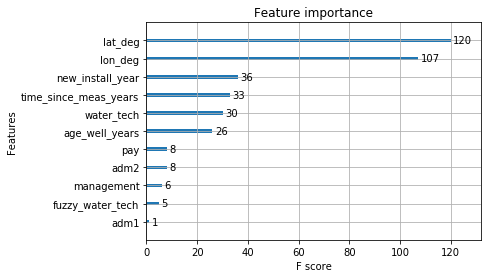

In [44]:
xgb.plot_importance(model_outer)

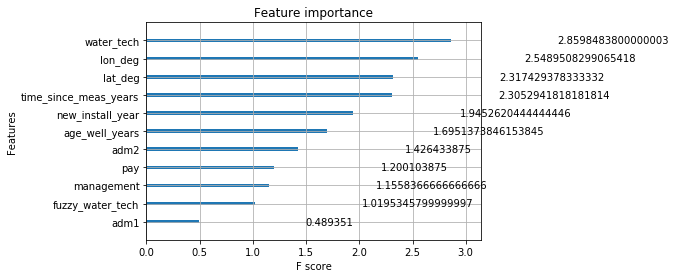

In [45]:
xgb.plot_importance(model_outer, importance_type='gain')

In [46]:
model_outer.feature_importances_

array([ 0.        ,  0.07894737,  0.01578947,  0.        ,  0.00263158,
        0.02105263,  0.02105263,  0.31578946,  0.28157896,  0.09473684,
        0.06842105,  0.0868421 ,  0.        ,  0.01315789], dtype=float32)

In [25]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

In [26]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

In [47]:
imp

array([  0.00000000e+00,  -1.03480004e-03,   3.43423650e-04,
         0.00000000e+00,  -3.44328234e-05,  -1.86573679e-05,
        -9.53325209e-05,  -5.62855305e-03,  -2.28793439e-03,
        -1.03538073e-03,  -9.73842817e-04,  -2.67398338e-03,
         0.00000000e+00,  -1.25241582e-04])

In [28]:
X_test.columns

Index(['water_source', 'water_tech', 'management', 'source', 'adm1', 'adm2',
       'pay', 'lat_deg', 'lon_deg', 'new_install_year', 'age_well_years',
       'time_since_meas_years', 'fuzzy_water_source', 'fuzzy_water_tech'],
      dtype='object')

In [29]:
def plot_perm_importance(perm_importance, X_test):
    #takes a permutatino importance and the input data from it and plots
    df = pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0)
    df.rename(columns={0:'Feature Importance'},inplace=True)
    df.sort_values(by='Feature Importance').plot(kind='barh',
                    title='Feature Importance', legend=None)


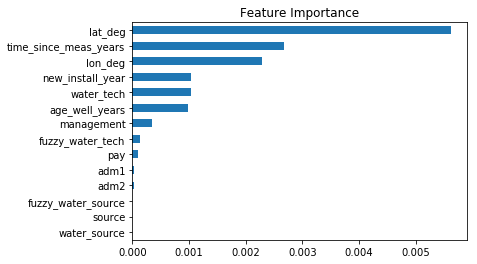

In [30]:
plot_perm_importance(imp, X_test)

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

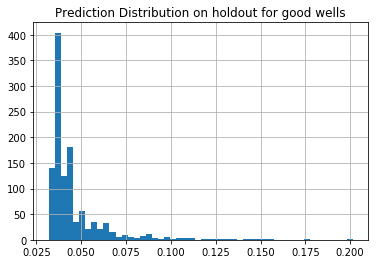

In [31]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


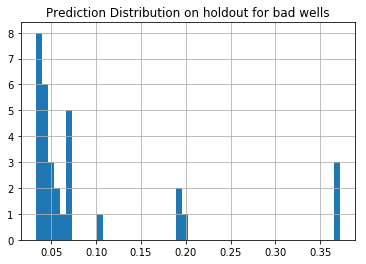

In [32]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 29.44011551,  29.44011551,  11.04004331,   3.68001444,
         18.40007219,   0.        ,   0.        ,   0.        ,
          3.68001444,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   3.68001444,   7.36002888,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  11.04004331]),
 array([ 0.03263579,  0.04112761,  0.04961942,  0.05811124,  0.06660305,
         0.07509487,  0.08358668,  0.09207849,  0.10057031,  0.10906212,
         0.11755394,  0.12604575,  0.13453757,  0.14302938,  0.1515212 ,
         0.16001301,  0.16850483,  0.17699664,  0.18548845,  0.19398027,
         0.20247208,  0.2109639 ,  0.21945571,  0.22794753,  0.236

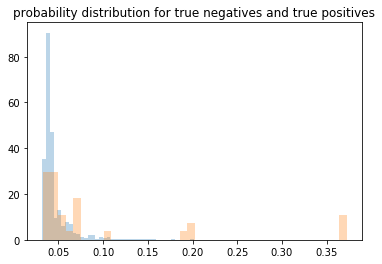

In [33]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### Some separation, will need to adjust the threshold

In [34]:
def evaluate_prediction_thresholds(y_true, y_pred_probs, recall_val):
    import numpy as np
    d = dict()
    for i in np.linspace(0,0.5, num=20):
        best = 0
        test = np.where(y_pred_probs > i, 1,0)
        recall = metrics.recall_score(y_true, test)
        precision = metrics.precision_score(y_true, test)
        f_score = metrics.f1_score(y_true, test, average='binary')
        d[i]=recall, precision, f_score

    frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
    frame.columns=(['recall','precision', 'f1_score'])
    frame = frame[frame.recall>recall_val]
    return frame

In [35]:
evaluate_prediction_thresholds(y_test, dtest_predprob, .1)

,recall,precision,f1_score
0.000000,1.00000,0.027188,0.052936
0.026316,1.00000,0.027188,0.052936
0.052632,0.46875,0.063559,0.111940
0.078947,0.28125,0.150000,0.195652
0.105263,0.28125,0.257143,0.268657
0.131579,0.25000,0.400000,0.307692


ouch.  Low precision

In [38]:
evaluate_prediction_thresholds(y_holdout, dholdout_predprob, 0.1)

,recall,precision,f1_score
0.000000,1.00000,0.027165,0.052893
0.026316,1.00000,0.027165,0.052893
0.052632,0.46875,0.070423,0.122449
0.078947,0.21875,0.107692,0.144330
0.105263,0.18750,0.200000,0.193548
0.131579,0.18750,0.400000,0.255319
0.157895,0.18750,0.750000,0.300000
0.184211,0.18750,0.857143,0.307692


In [60]:
new_thresh_preds = np.where(dholdout_predprob>0.052632,1,0)
metrics.confusion_matrix(y_holdout, new_thresh_preds)

array([[948, 198],
       [ 17,  15]])

## Modeling Decision: India is really bad.  Need to try new algorithms. Perhaps RF

In [52]:
clf = sk.ensemble.RandomForestClassifier( n_estimators=300, max_depth=None,  min_samples_leaf=10, min_samples_split=2, 
                                         max_leaf_nodes=5000, bootstrap=True) 
                                  

In [53]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=5000,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [58]:
#Predict training set:
rftrain_predictions = clf.predict(X_train)
rftrain_predprob = clf.predict_proba(X_train)[:,1]
rftest_predprob = clf.predict_proba(X_test)[:,1]
rftest_predictions = clf.predict(X_test)

#predict on the holdout set
rfholdout_predprob = clf.predict_proba(X_holdout)[:,1]
rfholdout_predictions = clf.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, rftrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, rftrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, rftest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, rfholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          rfholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 64
Accuracy for outer nested_cv model on training data: 0.9725
AUC Score (Train) for outer nested_cv model: 0.969967
AUC Score (Test) for outer nested_cv model: 0.722298
AUC Score (Holdout) for outer nested_cv model: 0.743701
Accuracy for outer nested_cv model on holdout data: 0.9728


In [56]:
print(metrics.confusion_matrix(rfholdout_predictions, y_holdout))

[[1146   32]
 [   0    0]]


In [59]:
print(metrics.confusion_matrix(rftest_predictions, y_test))

[[1145   32]
 [   0    0]]


### Create predictions for the out years based on data

In [14]:
model_outer=pickle.load(open('India_pickle.sav', 'rb'))

In [16]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
237869,0,1,3,0,1,2,73,21.0066,85.7769,60,6.2,2.6,0,4


In [17]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4

In [18]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today['age_well_years'][:1])
print(X_1year['age_well_years'][:1])
print(X_3year['age_well_years'][:1])
print(X_5year['age_well_years'][:1])

        age_well_years  time_since_meas_years
237869             3.6                    2.6
237869    6.2
Name: age_well_years, dtype: float64
237869    7.2
Name: age_well_years, dtype: float64
237869    9.2
Name: age_well_years, dtype: float64
237869    11.2
Name: age_well_years, dtype: float64


# Get Predictions for Today, 1, 3 and 5 years out

In [19]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [20]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [66]:
#old way before adjusting time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,5887.000000,5887.0,5887.0,5887.0,5887.0
mean,0.027348,0.0,0.0,0.0,0.0
std,0.163110,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,0.0
max,1.000000,0.0,0.0,0.0,0.0


In [21]:
#new way
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,5887.000000,5887.0,5887.0,5887.0,5887.0
mean,0.027348,0.0,0.0,0.0,0.0
std,0.163110,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,0.0
max,1.000000,0.0,0.0,0.0,0.0


# Setting a modeling decision of 0.052632 for our prediction threshold. It gives terrible precision but allows us to find some wells

# Also coerce well status to be "broken" if it was ever "broken" in the past 

In [22]:
threshold = 0.052632
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [23]:
ind = df.loc[df.country_name=='India']

In [75]:
#old way before adjusting time to measure
coerced = append_outyear_predictions(ind, 0.052632, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [24]:
#with corrected time to measure 
coerced2 = append_outyear_predictions(ind, 0.052632, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [76]:
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000
mean,0.027348,0.206727,0.751486,0.987430,0.987430
std,0.163110,0.404992,0.432188,0.111419,0.111419
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000
mean,0.027348,0.206727,0.206897,0.212842,0.214201
std,0.163110,0.404992,0.405115,0.409352,0.410302
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
#check to see if it worked
sl[(sl.status_binary==1)&(sl.status_binary<sl.today_preds)].shape

(0, 23)

In [27]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
coerced[coerced.status_binary==1][(coerced.today_preds<coerced.one_year_preds)].shape

NameError: name 'coerced' is not defined

In [ ]:
sl[sl.status_binary==0][(sl.today_preds<sl.three_year_preds)].tail(10)

In [58]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89       962
        1.0       0.65      0.28      0.39       256

avg / total       0.79      0.82      0.79      1218



In [80]:
#outputting with consistent failed wells coerced over time
coerced.to_csv('India_w_outyear_predictions_coerced.csv')

In [29]:
#outputting with consistent failed wells coerced over time
coerced2.to_csv('India_w_outyear_predictions_coerced_correct_time.csv')